# Ecossistema da Ciência de Dados: Insights da Comunidade Data Science do Stack Exchange

Este projeto foi realizado como parte da conclusão de curso do MBA em Data Science e Analytics da USP/ESALQ.

## Instalar e importar pacotes

In [ ]:
# Pacotes para importar arquivos utilizando SPARK
%pip install pyspark==3.5.1
%pip install findspark
%pip install pyarrow
%pip install setuptools

#Pacotes para visualização de dados
%pip install matplotlib
%pip install seaborn
%pip install plotly

#Pacotes para manipulação de dados
%pip install pandas
%pip install numpy

#Pacotes para manipulação de linguagem natural
%pip install nltk
%pip install spacy

#Pacotes para machine learning
%pip install scikit-learn
%pip install transformers


  Using cached pyspark-3.5.1-py2.py3-none-any.whl
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)

   ---------------------------------------- 0/2 [py4j]
   ---------------------------------------- 0/2 [py4j]
   ---------------------------------------- 0/2 [py4j]
   -------------------- ------------------- 1/2 [pyspark]
   -------------------- ------------------- 1/2 [pyspark]
   -------------------- ------------------- 1/2 [pyspark]
   -------------------- ------------------- 1/2 [pyspark]
   -------------------- ------------------- 1/2 [pyspark]
   -------------------- ------------------- 1/2 [pyspark]
   -------------------- ------------------- 1/2 [pyspark]
   -------------------- ------------------- 1/2 [pyspark]
   -------------------- ------------------- 1/2 [pyspark]
   -------------------- ------------------- 1/2 [pyspark]
   -------------------- ------------------- 1/2 [pyspark]
   ------------------

In [1]:
#Pacotes para Importar dados com SPARK
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pandas as pd
import findspark
import os
import pyarrow.parquet as pq
import setuptools

#Pacotes para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

#Pacotes para manipulação de linguagem natural
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import spacy

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\valve/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Pacotes para analise de coocorrência
from itertools import combinations
from collections import Counter

# Importar arquivos de xml para pandas
Lista de todos os repositórios de perguntas e respostas disponíveis em https://meta.stackexchange.com/questions/224873/all-stack-exchange-data-dump-releases/224922#224922.

Utilizamos apenas os de Março de 2025 - https://communitydatadump.com/torrents/128a4d5b12d7738f9ab63e86c5b441c221fa8668.torrent

Este estudo utiliza apenas os arquivos Posts e Comments do Data Science e Meta Data Science foruns. 

In [11]:
# Encontrando as configurações para inicializar o Spark
findspark.init()

spark = SparkSession.builder \
    .appName("Spark Posts") \
    .config("spark.driver.host", "localhost") \
    .config("spark.jars", "file:///C:/Spark/spark-jars/spark-xml_2.12-0.16.0.jar") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.jars.packages", "com.databricks:spark-xml_2.12:0.16.0") \
    .config("spark.driver.memory", "8g") \
    .master("local[*]") \
    .getOrCreate()



In [3]:
def get_file_path(file_name, read=False):
    current_dir = os.getcwd() # Obtem o diretório atual

    if read:
        # Se o parâmetro read for True, adiciona a pasta "data\processed" ao caminho atual
        current_dir = os.path.join(current_dir, "data", "proc")
    else:
        # Se o parâmetro read for False, adiciona a pasta "data\raw" ao caminho atual
        # Isso é útil para manter os arquivos de entrada e saída organizados
        current_dir = os.path.join(current_dir, "data", "raw")

    return os.path.join(current_dir, file_name)

In [ ]:
# Definindo os caminhos dos arquivos XML para Data Science e Data Science Meta
path_ds_posts = get_file_path("ds_posts.xml")
path_ds_comments = get_file_path("ds_comments.xml")

path_dsm_posts = get_file_path("dsmeta_posts.xml")
path_dsm_comments = get_file_path("dsmeta_comments.xml")

In [4]:
def ler_xml(file_path, data_corte='2020-01-01 00:00:00',salvar_parquet=True, qa=False):
    """
    Função para ler arquivos XML e retornar um DataFrame Pandas filtrado por data de criação.
    Parâmetros:
    - file_path: Caminho do arquivo XML a ser lido.
    - data_corte: Data de corte para filtrar os posts (formato 'YYYY-MM-DD HH:MM:SS').
    - salvar_parquet: Booleano para indicar se o DataFrame filtrado deve ser salvo como Parquet.
    Retorna:
    - DataFrame Pandas filtrado por data de criação.
    """
    
    file = 'file:///' + file_path

    df_spark = spark.read.format("xml") \
    .option("rowTag", "row") \
    .load(file)

    # print("Schema do DataFrame Spark:", file)
    # df_spark.printSchema()

    # Criar uma view temporária para executar consultas SQL
    df_spark.createOrReplaceTempView("posts")

    if qa:
        # incluir o tipo de post na query (apenas perguntas e respostas)
        query = "SELECT * FROM posts WHERE _CreationDate > '" + data_corte + "' AND _PostTypeId IN (1, 2)"
    else:
        # criar a query para filtrar os comentarios - apenas considerando CreationDate > 2020-01-01"
        query = "SELECT * FROM posts WHERE _CreationDate > '" + data_corte + "'"

    # Query em posts com a data de criação maior que 2020-01-01
    df_query = spark.sql(query)

    # Convertendo o DataFrame Spark para Pandas
    df_pandas = df_query.toPandas()

    if salvar_parquet:
        # Definindo o caminho para salvar o arquivo Parquet
        parquet_path = file_path.replace('.xml', '.parquet')
        parquet_path = parquet_path.replace('raw', 'proc')

        # Salvando o DataFrame como Parquet
        df_query.write.parquet(parquet_path, mode='overwrite')
        print(f"Arquivo Parquet salvo em: {parquet_path}")

    return df_pandas

# Lendo os arquivos XML
ds_posts_df = ler_xml(path_ds_posts,qa=True)
ds_comments_df = ler_xml(path_ds_comments)

NameError: name 'path_ds_posts' is not defined

# Importar parquet e iniciar análise exploratória 

In [36]:
# Definir os caminhos dos arquivos Parquet
# Definindo os caminhos dos arquivos XML para Data Science e Data Science Meta
path_ds_posts = get_file_path("ds_posts.parquet", read=True)
path_ds_comments = get_file_path("ds_comments.parquet", read=True)

# Importar parquet
ds_posts_df = pd.read_parquet(path_ds_posts)
ds_comments_df = pd.read_parquet(path_ds_comments)

In [6]:
# Informações dos DataFrames
print("DataFrame Perguntas e Respostas (ds_posts_df):")
print(ds_posts_df.info())

print("\nDataFrame Comentários (ds_comments_df):")
print(ds_comments_df.info())

DataFrame Perguntas e Respostas (ds_posts_df):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37216 entries, 0 to 37215
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   _AcceptedAnswerId       5132 non-null   float64       
 1   _AnswerCount            17906 non-null  float64       
 2   _Body                   37216 non-null  object        
 3   _ClosedDate             905 non-null    datetime64[ns]
 4   _CommentCount           37216 non-null  int64         
 5   _CommunityOwnedDate     19 non-null     datetime64[ns]
 6   _ContentLicense         37216 non-null  object        
 7   _CreationDate           37216 non-null  datetime64[ns]
 8   _Id                     37216 non-null  int64         
 9   _LastActivityDate       37216 non-null  datetime64[ns]
 10  _LastEditDate           11675 non-null  datetime64[ns]
 11  _LastEditorDisplayName  49 non-null     object        
 12 

In [ ]:
# Quantas perguntas (PostTypeId = 1) e respostas (PostTypeId = 2) existem?
tot_perguntas = ds_posts_df[ds_posts_df['_PostTypeId'] == 1].shape[0]
tot_respostas = ds_posts_df[ds_posts_df['_PostTypeId'] == 2].shape[0]
tot_comentarios = ds_comments_df.shape[0]

print("\nQuantidade de Perguntas (PostTypeId = 1):", tot_perguntas)
print("Quantidade de Respostas (PostTypeId = 2):", tot_respostas)
print("Quantidade de Comentários:", tot_comentarios)

# Quantas perguntas por resposta existem?
perg_resp_ratio = tot_respostas / tot_perguntas if tot_perguntas > 0 else 0
perg_com_ratio = tot_comentarios / tot_perguntas if tot_perguntas > 0 else 0
print("\nRelação Perguntas/Respostas:", perg_resp_ratio)
print("Relação Perguntas/Comentários:", perg_com_ratio)

#Colunas com valores nulos
print("Colunas com valores nulos em Perguntas e Respostas:")
print(ds_posts_df.isnull().sum())
print("\nColunas com valores nulos em Comentários:")
print(ds_comments_df.isnull().sum())


Quantidade de Perguntas (PostTypeId = 1): 17906
Quantidade de Respostas (PostTypeId = 2): 19310
Quantidade de Comentários: 37958

Relação Perguntas/Respostas: 1.0784094716854686
Relação Perguntas/Comentários: 2.11984809561041
Colunas com valores nulos em Perguntas e Respostas:
_AcceptedAnswerId         32084
_AnswerCount              19310
_Body                         0
_ClosedDate               36311
_CommentCount                 0
_CommunityOwnedDate       37197
_ContentLicense               0
_CreationDate                 0
_Id                           0
_LastActivityDate             0
_LastEditDate             25541
_LastEditorDisplayName    37167
_LastEditorUserId         25587
_OwnerDisplayName         36959
_OwnerUserId                193
_ParentId                 17906
_PostTypeId                   0
_Score                        0
_Tags                     19310
_Title                    19310
_ViewCount                19310
dtype: int64

Colunas com valores nulos em Coment

In [37]:
# Removendo colunas desnecessárias
def remove_unnecessary_columns(df, columns_to_remove):
    """
    Remove colunas desnecessárias de um DataFrame.
    
    Parâmetros:
    - df: DataFrame do qual as colunas serão removidas.
    - columns_to_remove: Lista de nomes das colunas a serem removidas.
    
    Retorna:
    - DataFrame com as colunas removidas.
    """
    return df.drop(columns=columns_to_remove)

In [38]:
#Listando as colunas que serão removidas
lista_colunas_remover_1 = ['_AcceptedAnswerId','_CommunityOwnedDate','_ContentLicense','_LastActivityDate',
                           '_LastEditDate','_LastEditorDisplayName','_LastEditorUserId','_OwnerDisplayName',
                           '_OwnerUserId']
lista_colunas_remover_2 = ['_Id','_ContentLicense','_UserDisplayName','_UserId']

# Removendo as colunas desnecessárias dos DataFrames
ds_posts_df = remove_unnecessary_columns(ds_posts_df, lista_colunas_remover_1)
ds_comments_df = remove_unnecessary_columns(ds_comments_df, lista_colunas_remover_2)

In [ ]:
# Juntar _Body e _Title em uma nova coluna '_Text' para perguntas e respostas
#Para perguntas, juntar o corpo e o título
ds_posts_df['_Title'] = ds_posts_df['_Title'].fillna('')  # Preencher valores nulos com string vazia
ds_posts_df['text'] = ds_posts_df['_Body'] + ' ' + ds_posts_df['_Title']

# Colocar todos os registros (perguntas, respostas e comentários) em um único DataFrame
df_todos = ds_posts_df.copy()

#Remover os comentários que foram feitos em perguntas que não estão no DataFrame de perguntas 
# (criadas antes de 2020-01-01)
ds_comments_df = ds_comments_df[ds_comments_df['_PostId'].isin(ds_posts_df['_Id'])]

# Adicionar uma coluna '_PostTypeId' com o valor 3 para comentários
ds_comments_df['_PostTypeId'] = 3
ds_comments_df.rename(columns={'_Text': 'text'}, inplace=True)

# Concatenar os DataFrames
df_todos = pd.concat([df_todos, ds_comments_df], ignore_index=True)

# Processar as tags das perguntas
Apenas as perguntas possuem tags. Para a análise, os comentários e respostas vão herdar as tags advindas das perguntas.
Cada pergunta tem 1 ou mais tags.

In [39]:
def tags_perguntas(df):
    df_tags_perguntas = df['_Tags'].str.split('><', expand=True)
    df_tags_perguntas.dropna(axis=0, how='all', inplace=True) 
    df_tags_perguntas = df_tags_perguntas.applymap(lambda x: x.strip('<>') if x is not None else x)

    # Vamos contar a frequência de cada tag
    tag_counts_perguntas = df_tags_perguntas.stack().value_counts()

    return df_tags_perguntas, tag_counts_perguntas

tags_perguntas_df, tag_counts_perguntas = tags_perguntas(ds_posts_df)

C:\Users\valve\AppData\Local\Temp\ipykernel_4260\171855251.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_tags_perguntas = df_tags_perguntas.applymap(lambda x: x.strip('<>') if x is not None else x)


Número de tags únicas: 684
Tags mais comuns em perguntas:
machine-learning    5234
python              3210
deep-learning       2460
neural-network      1732
nlp                 1571
classification      1517
keras               1225
tensorflow          1127
scikit-learn        1120
time-series         1019
Name: count, dtype: int64


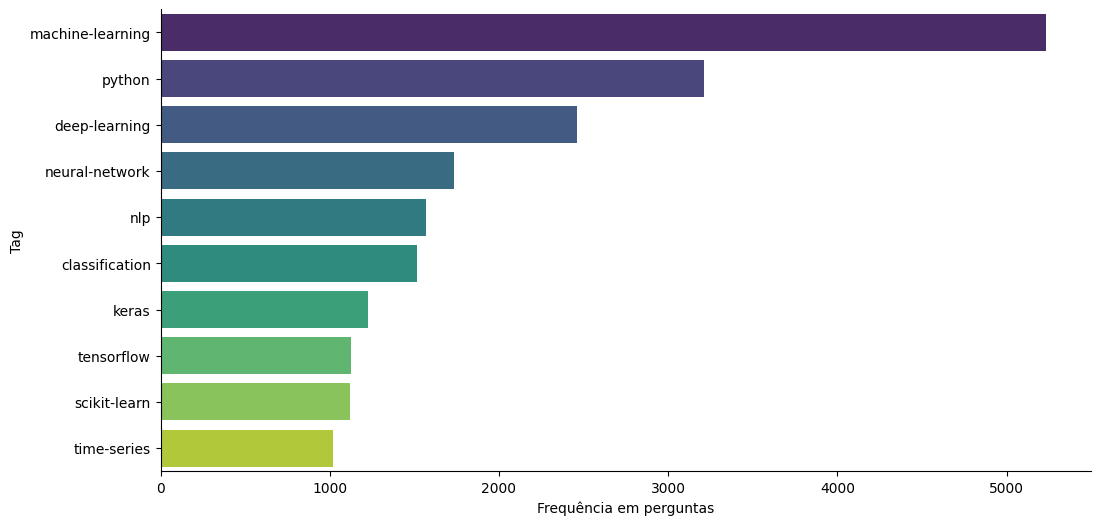

In [40]:
def analise_tags(df, tag_counts_perguntas):
    # print("Postagens sem tags:", df['_Tags'].isnull().sum())
    print("Número de tags únicas:", len(tag_counts_perguntas))
    print("Tags mais comuns em perguntas:")
    print(tag_counts_perguntas.head(10))

    #plot as tags mais comuns e suas frequências
    plt.figure(figsize=(12, 6))
    sns.barplot(x=tag_counts_perguntas.head(10).values, y=tag_counts_perguntas.head(10).index,  palette='viridis',hue=tag_counts_perguntas.head(10).index, legend=False)
    # plt.title('Tags mais comuns em perguntas')
    plt.xlabel('Frequência em perguntas')
    plt.ylabel('Tag')
    sns.despine(left=False,bottom=False)
    plt.show()


analise_tags(ds_posts_df, tag_counts_perguntas)

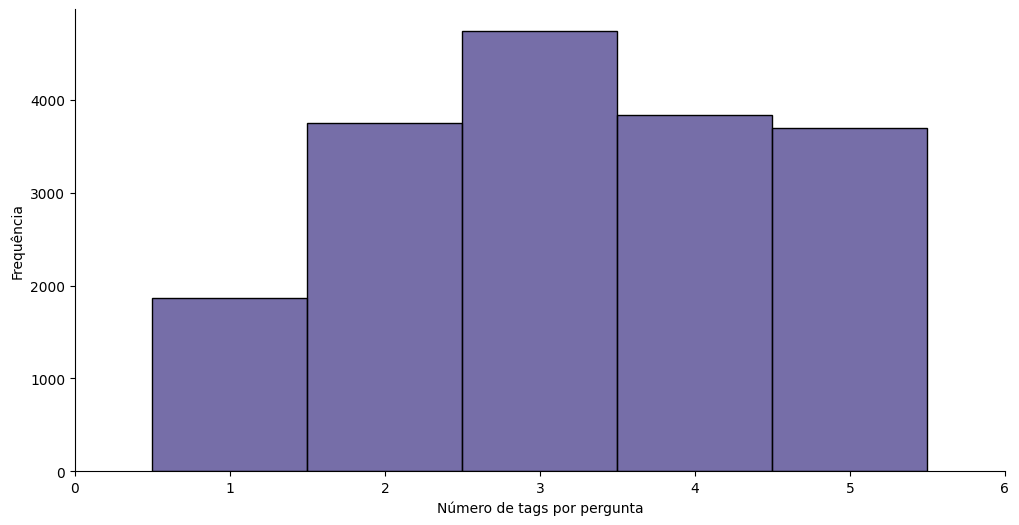

In [41]:
# plot o numero de tags por pergunta num histograma
#quantas tags por pergunta?
def tags_por_pergunta(df_tags_perguntas):
    tags_per_question = df_tags_perguntas.count(axis=1)

# plotar utilizando seaborn o numero de tags por pergunta
    plt.figure(figsize=(12, 6))
    sns.histplot(tags_per_question, bins=10, color='darkslateblue', discrete=True)   # axis x apenas com numeros inteiros, de 1 até o máximo de tags por pergunta
    plt.xlim(0, int(tags_per_question.max()) + 1)
    # plt.xticks(range(0, int(tags_per_question.max()) + 1))
    # plt.title('Distribuição do número de tags por pergunta')
    plt.xlabel('Número de tags por pergunta')
    plt.ylabel('Frequência')
    sns.despine(left=False,bottom=False)
    plt.show()

tags_por_pergunta(tags_perguntas_df)

# Análise de Co-ocorrências
Esta análise foca em encontrar quais pares de tags ocorrem com mais frequencia

In [45]:
# Apenas as perguntas possuem tags, então vamos copiar estas tags para as respostas e comentários
# 1. Criar um mapa de _Id da Pergunta para _Tags
# Filtrar apenas as perguntas (_PostTypeId == 1)
# e criamos uma Series onde o índice é o _Id da pergunta e o valor são as _Tags.
question_tags_map = df_todos[df_todos['_PostTypeId'] == 1].set_index('_Id')['_Tags']

# Visualizando o mapa criado (opcional)
# print("\nMapa de Tags das Perguntas (_Id -> _Tags):")
# print(question_tags_map)
# print("-" * 30)

# 2. Identificar as linhas que são respostas ou comentários
answer_rows_filter = (df_todos['_PostTypeId'] == 2) | (df_todos['_PostTypeId'] == 3)

# 3. Usar o _ParentId das respostas para buscar as _Tags no mapa
# A coluna _ParentId nas respostas corresponde ao _Id nas perguntas.
# Usamos .map() para aplicar o mapeamento.
# Usamos .loc para atribuir os valores de volta ao DataFrame original ou a uma cópia,
# evitando SettingWithCopyWarning e garantindo a atribuição correta.

# Primeiro, obtemos a Series de tags mapeadas para as respostas
mapped_tags_for_answers = df_todos.loc[answer_rows_filter, '_ParentId'].map(question_tags_map)

# Agora, atribuímos essas tags mapeadas à coluna '_Tags' das linhas de resposta
df_todos.loc[answer_rows_filter, '_Tags'] = mapped_tags_for_answers

# DataFrame Resultante
print("\nDataFrame com Tags Propagadas para Respostas:")
print(df_todos.head())


DataFrame com Tags Propagadas para Respostas:
   _AnswerCount                                              _Body  \
0           0.0  <p>I am working on a time series dataset in wh...   
1           1.0  <p>I have a NLP problem statement where I use ...   
2           2.0  <p>I am training a classification model with 3...   
3           NaN  <p>When implementing a model from a paper to r...   
4           NaN  <p>Try <a href="https://datalore.jetbrains.com...   

  _ClosedDate  _CommentCount           _CreationDate       _Id  _ParentId  \
0         NaT            2.0 2023-09-26 07:32:54.660  123853.0        NaN   
1         NaT            0.0 2020-10-06 12:44:24.030   82623.0        NaN   
2         NaT            0.0 2023-09-21 05:37:13.300  123786.0        NaN   
3         NaT            1.0 2020-01-04 22:30:09.460   65876.0    65721.0   
4         NaT            0.0 2021-11-06 08:43:44.343  103877.0    63101.0   

   _PostTypeId  _Score                                              _

In [49]:
# 1. Separar as tags de cada post em uma nova coluna
df_todos['sep_tags'] = df_todos['_Tags'].str.replace('<', ' ').str.replace('>', ' ')
# ds_posts_df.dropna(subset=['sep_tags'], inplace=True)

# Lidar com valores vazios na coluna '_Tags' e criar uma nova coluna 'sep_tags'
df_todos['sep_tags'] = df_todos['sep_tags'].fillna('')
df_todos['tag_list'] = df_todos['sep_tags'].str.split(' ')

# *Filtrar apenas as perguntas (PostTypeId = 1) e criar uma coluna com as tags separadas
df_perguntas = df_todos[df_todos['_PostTypeId'] == 1].copy()

# 2. Gerar pares e 3. Contar pares de co-ocorrência
co_occurrence_counts = Counter()

for index, row in df_perguntas.iterrows():
    # Filtrar tags vazias ou nulas
    tags = [tag for tag in row['tag_list'] if tag]
    if not tags: # sair se não houver tags
        continue

    # Criar combinações de pares de tags
    # Ordenar as tags para que ('tagA', 'tagB') seja o mesmo que ('tagB', 'tagA')
    pairs = combinations(sorted(list(set(tags))), 2)
    co_occurrence_counts.update(pairs)

# Converter o contador de co-ocorrência para um DataFrame
if co_occurrence_counts: # Seguir somente se houver co-ocorrências
    co_occurrence_df = pd.DataFrame(co_occurrence_counts.items(), columns=['pair', 'count'])
    co_occurrence_df = co_occurrence_df.sort_values(by='count', ascending=False)

    print("Top co-occurring tag pairs (for _PostTypeId == 1):")
    print(co_occurrence_df.head(30))

    tagpairs = co_occurrence_df['pair'].tolist()
    print("\nTotal de pares de tags encontradas:", len(tagpairs))

    # 4. Criar uma matriz de co-ocorrência
    all_tags_list = [tag for sublist in df_todos['tag_list'] for tag in sublist if tag]
    if not all_tags_list:
        print("\nTags não encontradas para _PostTypeId == 1.")
    else:
        all_tags = sorted(list(set(all_tags_list)))

        # Inicializar a matriz de co-ocorrência
        co_occurrence_matrix = pd.DataFrame(0, index=all_tags, columns=all_tags)

        # Popular a matriz
        for pair, count in co_occurrence_counts.items():
            # Garantir que ambos os tags do par estão na lista de todas as tags
            if pair[0] in all_tags and pair[1] in all_tags:
                co_occurrence_matrix.loc[pair[0], pair[1]] = count
                co_occurrence_matrix.loc[pair[1], pair[0]] = count # Para uma matriz simétrica

        print("\nMatriz de o-ocorrência (primeiro 5x5 para _PostTypeId == 1):")
        if not co_occurrence_matrix.empty:
            print(co_occurrence_matrix.iloc[:min(5, len(all_tags)), :min(5, len(all_tags))])
        else:
            print("Matriz de co-ocorrência vazia.")

else:
    print("Não há matriz de co-ocorrencia para _PostTypeId == 1.")

Top co-occurring tag pairs (for _PostTypeId == 1):
                                            pair  count
243            (deep-learning, machine-learning)    974
55                    (machine-learning, python)    894
367           (machine-learning, neural-network)    612
291           (classification, machine-learning)    602
337              (deep-learning, neural-network)    573
98                           (keras, tensorflow)    546
227                       (python, scikit-learn)    421
59                       (machine-learning, nlp)    410
1075                            (pandas, python)    384
287             (machine-learning, scikit-learn)    352
160                       (deep-learning, keras)    333
97                               (keras, python)    318
256                  (deep-learning, tensorflow)    310
127                      (deep-learning, python)    303
306   (machine-learning, machine-learning-model)    298
191               (machine-learning, regression)    2